# Introduction to Deep Learning Assignment 01

@ Student NAME: Chuanbo HUA

@ Student ID: 49003366

@ DATE: 02/09/2019

## Requirements:
1. <a href='#section1'>Implement a PyTorch dataloader of the target dataset.</a>
2. <a href='#section2'>Experiment with increasing the degree of polynomials in the regression model and discuss the results regarding model capacity.</a>
  - <a href='#section2.1'>Implement the regression model using torch.nn.module.</a>
  - <a href='#section2.2'>Implement the gradient descent optimizer using torch.optim.</a>
  - <a href='#section2.3'>Draw a table of root mean square error values by increasing the degree of the polynomial regression model.</a>
  - <a href='#section2.4'>Identify the most highly correlated feature variables with the target variable by analyzing the results.</a>
3. <a href='#section3'>Add a regularization term (e.g., L2 norm, L1 norm) to your best model obtained above and redo the experiments above.</a>
4. <a href='#section4'>Select the best model through the 8-fold cross-validation by splitting the dataset into training/validation sets.</a>
5. <a href='#section5'>Compare the result obtained by SGD optimization to a closed-form least square solution.</a>

## Imports part

In [0]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms, utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns

## Implement a PyTorch dataloader
<a id='section1'>This is the requirement 1.</a>

Steps:

1. Load boston dataset to `house_dataset`. At this time, the type of `house_dataset` is `bunch`, and we can get the data individually;
2. Split the data to 4 parts, include: `data of train`, `price of train`, `data of test`, `price of test`;
3. Rewrite the `Dataset` to `TrainDataset` and `TestDataset` to prepare for future proccesses;
4. Create `dataloader`.  

In [0]:
house_dataset = load_boston()
house_data = house_dataset.data
house_price = house_dataset.target

x_train_np, x_test_np, y_train_np, y_test_np = train_test_split(house_data, house_price, test_size = 0.2, random_state = 1)
x_train = torch.tensor(x_train_np)
y_train = torch.tensor(y_train_np)
x_test = torch.tensor(x_test_np)
y_test = torch.tensor(y_test_np)

class TrainDataset(Dataset):
  def __init__(self):
    self.len = x_train.shape[0]
    self.x_traindata = x_train
    self.y_traindata = y_train
  def __getitem__(self, index):
    return self.x_traindata[index], self.y_traindata[index]
  def __len__(self):
    return self.len

class TestDataset(Dataset):
  def __init__(self):
    self.len = x_test.shape[0]
    self.x_testdata = x_test
    self.y_testdata = y_test
  def __getitem__(self, index):
    return self.x_testdata[index], self.y_testdata[index]
  def __len__(self):
    return self.len

train_dataset = TrainDataset()
test_dataset = TestDataset()
train_loader = DataLoader(train_dataset, batch_size=101, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=101, shuffle=True)

## Implement the regression model
<a id='section2'><a id='section2.1'>This is the requirement 2.</a></a>

Steps:

1. Rewrite the function `nn.Module`, use the linear method to layers, and change the `forward` function;
2. Create model and set the parameters of different layers;

And then, <a id='section2.1'>set the gradient descent optimizer from torch.optim.</a> I chose to set the `learning rate`, `lr`, to 0.01.

In [0]:
class Net(nn.Module):  
  def __init__(self, inputs, hidden, outputs):
    super(Net, self).__init__()
    self.hidden = nn.Linear(inputs, hidden)
    self.predict = nn.Linear(hidden, outputs)
  def forward(self, x):
    x = F.relu(self.hidden(x))
    x = self.predict(x)
    return x

model = Net(13, 20, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

## Start training
<a id='section2'><a id='section2.3'>This is the requirement 2.</a></a>

Steps:

1. At the start of each training round, we get data by `dataLoader` and it is necessary to fix the data type of these data;
2. Just like the conventional steps, set the `grad` to 0 and then start training, record the loss, then backword it;
3. In the end of every round, it is necessary for us to output the total loss to evaluate the result of this round.

I chose to train the data for 30 rounds, and the result can be seen as the **running result**. 

In [67]:
for epoch in range(30):
  overall_loss = 0.0
  for i, (x, y) in enumerate(train_dataset):
    inputs = Variable(x).float()
    labels = Variable(y).float()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    overall_loss += loss.item()
  print(epoch, " loss: ", overall_loss)
  overall_loss = 0.0

def cal_mse(x, y=[]): 
  result = model(x.float()).data[:,0].numpy()
  mse = (np.sqrt(mean_squared_error(result, y.numpy())))
  print("mean squared error: ", mse)
  return pd.DataFrame(data={'actual':y.numpy(), 'predicted':result})

result_train = cal_mse(x_train, y_train)
result_test = cal_mse(x_test, y_test)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0  loss:  38248.21762887732
1  loss:  27684.101050294586
2  loss:  22817.22906373383
3  loss:  20496.260065014474
4  loss:  19229.897827675522
5  loss:  18198.694339477224
6  loss:  17568.584414884215
7  loss:  17205.15830503567
8  loss:  16793.40634998586
9  loss:  17119.65278463952
10  loss:  16720.422233975198
11  loss:  17061.257256489644
12  loss:  16738.62199621403
13  loss:  16481.88192882558
14  loss:  16477.65616654427
15  loss:  16134.651664071502
16  loss:  16249.253328851017
17  loss:  15967.15865418897
18  loss:  15701.4649520549
19  loss:  15548.559694883646
20  loss:  15424.267785606415
21  loss:  15294.33490710185
22  loss:  14941.578015077044
23  loss:  14706.969470621669
24  loss:  14126.0757811447
25  loss:  13879.542445659536
26  loss:  13757.33013758756
27  loss:  13460.732636897708
28  loss:  13468.701682391198
29  loss:  13245.915891265497
mean squared error:  4.877969114429845
mean squared error:  5.01592005913378


<a id='section2.4'>Then, I referenced the method of the *Linear Regression on Boston Housing Dataset* and also output the heatmap to show the highly correlated features.</a>

As we can see, the `LSTAT` and `RM` play importrant roles in affecting the price. 

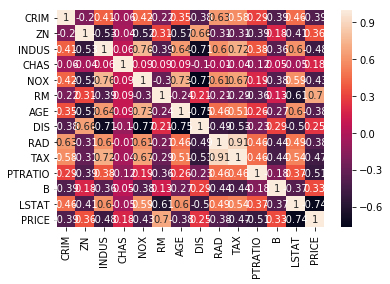

In [68]:
data_df = pd.DataFrame(house_data)
data_df.columns = house_dataset.feature_names
data_df['PRICE'] = house_price
correlation_matrix = data_df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

## Add a regularization term
<a id='section3'>This is requirement 3.</a>

I noticed that the torch.optim can set a L2 regularization term by fixing the input parameter. After fixing it, I rerun the code and got the results, and then compare it with the results before. 

The result of comparing is as following:

| |  Without L2 regularization term   | With L2 regularization term  |
| ---- |  ----  | ----  |
|Train error | 4.877969  | 5.027101 |
|Test error| 5.015920 | 5.165297 |

Although the regularization is used to deal with the problem of overfitting, but in my module, the 30 rounds training may not fit enough, so at this time, the regularization my affect the efferency of fitting. But we can also learn from the result that the gap between trian error and test error is narrowed by using this method. 

In [4]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms, utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns

house_dataset = load_boston()
house_data = house_dataset.data
house_price = house_dataset.target

x_train_np, x_test_np, y_train_np, y_test_np = train_test_split(house_data, house_price, test_size = 0.2, random_state = 1)
x_train = torch.tensor(x_train_np)
y_train = torch.tensor(y_train_np)
x_test = torch.tensor(x_test_np)
y_test = torch.tensor(y_test_np)

class TrainDataset(Dataset):
  def __init__(self):
    self.len = x_train.shape[0]
    self.x_traindata = x_train
    self.y_traindata = y_train
  def __getitem__(self, index):
    return self.x_traindata[index], self.y_traindata[index]
  def __len__(self):
    return self.len

class TestDataset(Dataset):
  def __init__(self):
    self.len = x_test.shape[0]
    self.x_testdata = x_test
    self.y_testdata = y_test
  def __getitem__(self, index):
    return self.x_testdata[index], self.y_testdata[index]
  def __len__(self):
    return self.len

train_dataset = TrainDataset()
test_dataset = TestDataset()
train_loader = DataLoader(train_dataset, batch_size=101, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=101, shuffle=True)

class Net(nn.Module):  
  def __init__(self, inputs, hidden, outputs):
    super(Net, self).__init__()
    self.hidden = nn.Linear(inputs, hidden)
    self.predict = nn.Linear(hidden, outputs)
  def forward(self, x):
    x = F.relu(self.hidden(x))
    x = self.predict(x)
    return x

model = Net(13, 20, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_func = torch.nn.MSELoss()

for epoch in range(30):
  overall_loss = 0.0
  for i, (x, y) in enumerate(train_dataset):
    inputs = Variable(x).float()
    labels = Variable(y).float()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    overall_loss += loss.item()
  print(epoch, " loss: ", overall_loss)
  overall_loss = 0.0

def cal_mse(x, y=[]): 
  result = model(x.float()).data[:,0].numpy()
  mse = (np.sqrt(mean_squared_error(result, y.numpy())))
  print("mean squared error: ", mse)
  return pd.DataFrame(data={'actual':y.numpy(), 'predicted':result})

result_train = cal_mse(x_train, y_train)
result_test = cal_mse(x_test, y_test)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0  loss:  212252.0012342087
1  loss:  32817.20930737443
2  loss:  29777.498808139586
3  loss:  27695.439027496614
4  loss:  25657.078307097952
5  loss:  23678.424326985492
6  loss:  22013.956417949757
7  loss:  20683.514856145383
8  loss:  19520.188218545634
9  loss:  18665.90388914384
10  loss:  17902.854223918315
11  loss:  17316.713867090642
12  loss:  16816.89796389311
13  loss:  16419.08709957992
14  loss:  16055.979131269298
15  loss:  15716.553783300216
16  loss:  15404.1325493271
17  loss:  15097.645122694317
18  loss:  14854.899994536012
19  loss:  14629.268230034868
20  loss:  14447.206462387563
21  loss:  14236.626984161558
22  loss:  14063.674485492254
23  loss:  13897.704735128122
24  loss:  13737.842018347234
25  loss:  13532.19193261111
26  loss:  13334.778696025722
27  loss:  13170.820173409942
28  loss:  13015.456605119165
29  loss:  12873.667889171978
mean squared error:  5.732819438085562
mean squared error:  6.606211523938473


## Try the 8-fold cross-validation
<a id='section4'>This is requirement 4.</a>

To complete the cross validation, I should to fix the method about spliting dataset.  We can use the method named StratifiedKrold. And here is an example.

In [36]:
X=np.array([
    [1,2,3,4],
    [11,12,13,14],
    [21,22,23,24],
    [31,32,33,34],
    [41,42,43,44],
    [51,52,53,54],
    [61,62,63,64],
    [71,72,73,74],
    [11,12,13,14],
    [21,22,23,24],
    [31,32,33,34],
    [41,42,43,44],
    [51,52,53,54],
    [61,62,63,64],
    [71,72,73,74],
    [61,62,63,64]
])
y=np.array([1,1,0,0,1,1,0,0,1,0,0,1,0,1,1,0])

kfold = StratifiedKFold(n_splits=8, random_state=1)
for train, test in kfold.split(X, y):
  print(train, test)

[ 1  3  4  5  6  7  8  9 10 11 12 13 14 15] [0 2]
[ 0  2  4  5  6  7  8  9 10 11 12 13 14 15] [1 3]
[ 0  1  2  3  5  7  8  9 10 11 12 13 14 15] [4 6]
[ 0  1  2  3  4  6  8  9 10 11 12 13 14 15] [5 7]
[ 0  1  2  3  4  5  6  7 10 11 12 13 14 15] [8 9]
[ 0  1  2  3  4  5  6  7  8  9 12 13 14 15] [10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 14 15] [12 13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] [14 15]


## Result obtained by SGD optimization
<a id='section5'>This is requirement 5.</a>

If we choose to use the SGD optimizer, we can got the result as following.

Compared the mse of SGD optimizer with closed-form least square solution's, we got this table:

| |  SGD optimizer   | Closed-form lease square solution  |
| ---- |  ----  | ----  |
|Train error | 8.987936  | 5.637129 |
|Test error| 9.941626 | 5.137400 |

*The data of Closed-form lease square solution result is referenced from [Linear Regression on Boston Housing Dataset](https://towardsdatascience.com/linear-regression-on-boston-housing-dataset-f409b7e4a155)*

I was courious about that why the error of SGD is so high, and after searcing, I got such a image: 

![img](https://ptorch.oss-cn-beijing.aliyuncs.com/uploads/2017090721345389920.jpg)

*Referenced from https://ptorch.com/news/54.html*

So through my limited steps, SGD optimizer can hardly performance better than other three methods. SGD is the most common optimizer, it can be said that there is no acceleration effect, and Momentum is a modified version of SGD, which incorporates the momentum principle. The latter RMSprop is an upgraded version of Momentum. And Adam is an upgraded version of RMSprop. In this result, we see that Adam's effect seems to be better than SGD. So it is the more advanced optimizer , the better the result here. We can try different optimizers in our own experiments, find the one that works best for us.

And as for the Closed-form lease square solution, I got to know that the result of Adam is better than it, about 4.877969. 


In [13]:
model = Net(13, 20, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_func = torch.nn.MSELoss()

for epoch in range(30):
  overall_loss = 0.0
  for i, (x, y) in enumerate(train_dataset):
    inputs = Variable(x).float()
    labels = Variable(y).float()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    overall_loss += loss.item()
  print(epoch, " loss: ", overall_loss)
  overall_loss = 0.0

def cal_mse(x, y=[]): 
  result = model(x.float()).data[:,0].numpy()
  mse = (np.sqrt(mean_squared_error(result, y.numpy())))
  print("mean squared error: ", mse)
  return pd.DataFrame(data={'actual':y.numpy(), 'predicted':result})

result_train = cal_mse(x_train, y_train)
result_test = cal_mse(x_test, y_test)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0  loss:  1.2817112598899183e+25
1  loss:  1036508.1716979365
2  loss:  36912.69529551972
3  loss:  36912.69529551972
4  loss:  36912.69529551972
5  loss:  36912.69529551972
6  loss:  36912.69529551972
7  loss:  36912.69529551972
8  loss:  36912.69529551972
9  loss:  36912.69529551972
10  loss:  36912.69529551972
11  loss:  36912.69529551972
12  loss:  36912.69529551972
13  loss:  36912.69529551972
14  loss:  36912.69529551972
15  loss:  36912.69529551972
16  loss:  36912.69529551972
17  loss:  36912.69529551972
18  loss:  36912.69529551972
19  loss:  36912.69529551972
20  loss:  36912.69529551972
21  loss:  36912.69529551972
22  loss:  36912.69529551972
23  loss:  36912.69529551972
24  loss:  36912.69529551972
25  loss:  36912.69529551972
26  loss:  36912.69529551972
27  loss:  36912.69529551972
28  loss:  36912.69529551972
29  loss:  36912.69529551972
mean squared error:  8.987936380880168
mean squared error:  9.941626222309782
